In [1]:
!pip install -Uqq portalocker>=2.0.0
# !pip install -qq torchtext
!pip install -qq torchdata
!pip install -Uqq plotly
!pip install -qq dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 51.3 MB/s eta 0:00:00


In [2]:
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cpu
!pip install torchtext==0.15.2

Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 3.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.4.1+cu121
    Uninstalling torch-2.4.1+cu121:
      Successfully uninstalled torch-2.4.1+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.19.1+cu121
    Uninstalling torchvision-0.19.1+cu121:
      Successfully uninstalled torchvision-0.19.1+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.4.1+cu121
    Uninstalling torchaudio-2.4.1+cu121:
      Successfully uninstalled torchaudio-2.4.1+cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 76.3 MB/s eta 0:00:00
  Att

In [3]:
!pip install revtok

In [4]:
import torch
import torchtext

print(torch.__version__)
print(torchtext.__version__)

2.0.1+cpu
0.15.2+cpu


In [5]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import numpy as np
from torchtext.datasets import AG_NEWS
from IPython.display import Markdown as md
from tqdm import tqdm

from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import AG_NEWS
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from sklearn.manifold import TSNE
import plotly.graph_objs as go

from torchtext.data.utils import get_tokenizer

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# EDA

In [31]:
#check content with iter & next
train_iter = iter(AG_NEWS(split="train"))

y, text = next((train_iter))
print(y, text)

y_next, text_next = next((train_iter))
print(y_next, text_next)

print(len(list(train_iter))) #attention: this will exhausted the iteration

3 Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
3 Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
119998


In [32]:
#how many classes are there: https://paperswithcode.com/dataset/ag-news
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
print(ag_news_label[y])

train_iter = iter(AG_NEWS(split="train"))
num_class = len(set([label for (label, text) in train_iter ]))
print(num_class)

Business
4


# Data Preprocessing

## a. Tokenization & Numerization

In [33]:
#tokenization
train_iter = iter(AG_NEWS(split="train"))
tokenizer = get_tokenizer("basic_english") #this will just lowercase and split by space, can try other tokenizers like 'subword'

def yield_tokens(data_iter):
  for _, text in data_iter:
    tokens = tokenizer(text)
    yield tokens

#numerization (built on training set)
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab['<unk>'])

In [36]:
#check numerization result:
# print(vocab.get_stoi()) #token-index relations

target_tp = [key for key, value in vocab.get_stoi().items() if value == 2]
print(target_tp) #when index=2 which token it refers to

print(vocab(["commercial", "black"])) #need to lowercase

['the']
[1310, 848]


## b. Split Train-Validation-Test

In [10]:
train_iter, test_iter = AG_NEWS()

#convert iterators to map-stype datasets, for later input into DataLoader
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
print(train_dataset[0])

#split validation set
train_size = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = random_split(train_dataset, [train_size, len(train_dataset)-train_size])
print(len(split_train_), len(split_valid_), len(test_dataset))

(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")
114000 6000 7600


## c. DataLoader

In [11]:
#pipeline for label & text
def label_pipeline(x):
  return int(x) - 1

def text_pipeline(x):
  return vocab(tokenizer(x))

In [12]:
#collate_batch: customize batch creation:
#(1) tokenization & numerization & convert into PyTorch tensors & move to device
#(2) lable_list, text_list, offsets_list

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def collate_batch(batch):
  label_list, text_list, offsets = [], [], [0]
  for _label, _text in batch:
    label_list.append(label_pipeline(_label))
    processed_text = torch.tensor(text_pipeline(_text), dtype = torch.int64)
    text_list.append(processed_text)
    offsets.append(processed_text.size(0)) #append each text sequence's length first, e.g. [4, 5, 3]

  label_list = torch.tensor(label_list, dtype = torch.int64)
  offsets = torch.tensor(offsets[:-1]).cumsum(dim=0) #offset: starting position of each text sequence in the combined tensor e.g.[0, 4, 9, 12] --- remove lst one from [:-1] then would be [0, 4, 9]
  text_list = torch.cat(text_list)
  return label_list.to(device), text_list.to(device), offsets.to(device)

cpu


In [13]:
#dataloader
#parameters: dataset, batch_size, shuffle or not, collate_fn
BATCH_SIZE = 64
train_dataloader = DataLoader(
    split_train_, batch_size = BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size = BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size = BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [14]:
#check on first batch
label, text, offsets = next(iter(train_dataloader))
label, text, offsets

(tensor([3, 1, 3, 3, 3, 0, 1, 1, 0, 2, 1, 0, 2, 2, 2, 1, 1, 3, 2, 1, 1, 1, 2, 0,
         0, 0, 0, 0, 3, 3, 3, 0, 0, 3, 1, 1, 3, 0, 3, 2, 1, 2, 1, 2, 2, 0, 0, 0,
         2, 0, 0, 0, 0, 2, 1, 0, 1, 0, 3, 0, 0, 0, 2, 2]),
 tensor([ 180,  493, 4926,  ...,  838,  233,    1]),
 tensor([   0,   45,  106,  149,  187,  257,  293,  352,  389,  440,  487,  531,
          584,  630,  674,  710,  745,  775,  810,  864,  899,  955, 1002, 1061,
         1106, 1140, 1174, 1223, 1276, 1319, 1361, 1402, 1448, 1483, 1549, 1597,
         1632, 1666, 1700, 1738, 1769, 1826, 1869, 1906, 1945, 2009, 2033, 2070,
         2129, 2175, 2215, 2237, 2275, 2309, 2346, 2391, 2434, 2465, 2506, 2543,
         2593, 2629, 2670, 2710]))

In [15]:
print(len(label), len(text), len(offsets))

64 2743 64


# Neural Network

## a. No Training Model

### Define Model

In [16]:
from torch import nn

class TextClassificationModel(nn.Module):
  def __init__(self, vocab_size, embed_dim, num_class):
    super(TextClassificationModel, self).__init__()
    self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False) #embedding layer
    self.fc = nn.Linear(embed_dim, num_class) #fully connect layer
    self.init_weights() #initialize weights

  def init_weights(self):
    initrange = 0.5
    self.embedding.weight.data.uniform_(-initrange, initrange)
    self.fc.weight.data.uniform_(-initrange, initrange)
    self.fc.bias.data.zero_()

  def forward(self, text, offsets):
    embedded = self.embedding(text, offsets)
    return self.fc(embedded)


In [17]:
vocab_size = len(vocab)
emsize = 64
num_class = 4
print(vocab_size)

model = TextClassificationModel(vocab_size, emsize, num_class)
model

95811


TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

### Predict

In [18]:
predicted_label = model(text, offsets) #model trained with a mini-batch size of 64 samples
print(predicted_label.shape) #output shape: ([batch_size, num_classes])

torch.Size([64, 4])


In [19]:
def predict(text, text_pipeline):
  with torch.no_grad():
    text = torch.tensor(text_pipeline(text))
    output = model(text, torch.tensor([0]))
    # print(output.argmax(1).item())
    return ag_news_label[output.argmax(1).item() + 1]

predict('I like sports', text_pipeline) #accuracy so bad,, cuz we didn't train the model

'Sports'

### Evaluate

In [20]:
def evaluate(dataloader):
  model.eval()
  total_acc, total_count = 0, 0

  with torch.no_grad():
    for idx, (label, text, offsets) in enumerate(dataloader):
      predicted_label = model(text, offsets)

      total_acc += (predicted_label.argmax(1) == label).sum().item() #total true count for that batch (tensor with a single element) --- .item() convert tensor to scalar
      total_count += label.size(0)
    return total_acc / total_count

In [21]:
evaluate(test_dataloader)

0.23289473684210527

## b. Train Model

### Key Components

In [22]:
#learning rate, loss criterion, optimizer, learning rate scheduler

LR = 0.1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
# scheduler: adjusts LR during training, reducing it by a factor(gamma) of 0.1 after every epoch
# improve convergence and fine-tune model's performance

In [23]:
EPOCHS = 10
cum_loss_list = []
acc_epoch = []
acc_old = 0

for epoch in tqdm(range(1, EPOCHS+1)):
  model.train() #set the training mode for each epoch
  cum_loss = 0

  for idx, (label, text, offsets) in enumerate(train_dataloader):
    optimizer.zero_grad() #reset the gradients of model parameter to 0 (or will accumulate)
    predicted_label = model(text, offsets) #1. predict
    loss = criterion(predicted_label, label) #2. calculate loss
    loss.backward() #3. compute gradients for each parameter based on loss
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1) #prevent exploding gradients, by clipping them to a maximum norm of 0.1
    optimizer.step() #4. update the parameters based on computed gradients
    cum_loss += loss.item()

    #overall steps: predict, calculate loss, compute gradient, update parameters
    #loss.backward(): backpropagation, chain rules of calculus. update weight

  cum_loss_list.append(cum_loss)
  accu_val = evaluate(valid_dataloader)
  acc_epoch.append(accu_val)

  if accu_val > acc_old:
    acc_old = accu_val
    torch.save(model.state_dict(), 'my_model.pth')


100%|██████████| 10/10 [06:02<00:00, 36.30s/it]


### Plot Loss & Acc

In [24]:
def plot(COST, ACC):
  fig, ax1 = plt.subplots()
  color = 'tab:red'
  ax1.plot(COST, color = color)
  ax1.set_xlabel('epoch', color = color)
  ax1.set_ylabel('total loss', color = color)
  ax1.tick_params(axis='y', color = color)

  ax2 = ax1.twinx()
  color = 'tab:blue'
  ax2.set_ylabel('accuracy', color = color)
  ax2.plot(ACC, color = color)
  ax2.tick_params(axis='y', color = color)
  fig.tight_layout()

  plt.show()

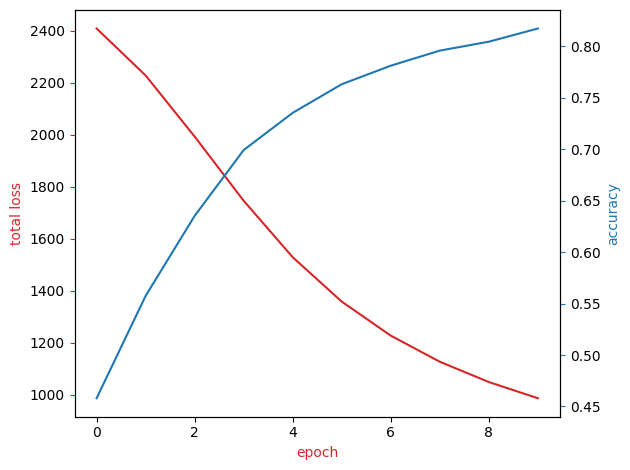

In [25]:
plot(cum_loss_list, acc_epoch)

In [26]:
evaluate(test_dataloader)

0.8185526315789474

### Test

In [27]:
article = """
China pledged on Saturday to "significantly increase" debt to revive its sputtering economy, but left investors guessing on the overall size of the stimulus package, a vital detail to gauge the longevity of its recent stock market rally.
"""

In [28]:
predict(article, text_pipeline)

'Business'

In [30]:
#load pre-trained model
model.load_state_dict(torch.load('my_model.pth'))
model.eval()

#test on a list of articles
new_articles = [
    "International talks have made significant headway with the signing of a climate accord that commits countries to reduce emissions by 40% over the next two decades. World leaders expressed optimism at the conclusion of the summit.",
    "In a stunning upset, the underdog team won the national title, beating the favorites in a match that featured an incredible comeback and a last-minute goal that sealed their victory in front of a record crowd.",
    "Market analysts are optimistic as the tech startup's stock prices soared after the announcement of their latest product, which promises to revolutionize how we interact with smart devices.",
    "A recent study published in a leading scientific journal suggests that a new drug has shown promise in the treatment of Alzheimer's disease, outperforming current leading medications in early clinical trials.",
    "Diplomatic relations have taken a positive turn with the recent peace talks that aim to end decades of conflict. The ceasefire agreement has been welcomed by the international community.",
    "Economic indicators show a sharp rebound in manufacturing, with the automobile industry leading the charge. Analysts predict this surge will result in significant job creation over the next year.",
    "Researchers at the university's astrophysics department have discovered a potentially habitable exoplanet. The planet, which lies in a nearby star system, has conditions that could support liquid water and, possibly, life.",
    "The sports world is in shock as a legendary player announces their retirement. Over an illustrious 20-year career, the athlete has amassed numerous records and is regarded as one of the greatest to ever play the game.",
    "A multinational corporation has announced a major investment in renewable energy. The initiative includes the construction of new wind farms and solar panels that will power hundreds of thousands of homes.",
    "Climate scientists warn that the melting of the polar ice caps has been accelerating at an alarming rate, raising sea levels and threatening coastal cities worldwide with increased flooding risks."
]

for i, article in enumerate(new_articles, start=1):
  prediction = predict(article, text_pipeline)
  print(f"Article {i}: {prediction}\n")


Article 1: World

Article 2: Sports

Article 3: Business

Article 4: Sci/Tec

Article 5: World

Article 6: Business

Article 7: Sci/Tec

Article 8: Sports

Article 9: Sci/Tec

Article 10: Sci/Tec

